In [2]:
from keras.layers import Dense, Input, LSTM, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
from keras.callbacks import TensorBoard
from keras.models import load_model
from keras.models import Model
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing import text
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, LSTM, Bidirectional
from keras.layers import Conv1D, Flatten
from keras.models import Sequential,Model
from keras.layers import Dense ,Activation,MaxPool1D,Conv1D,Flatten,Dropout,Activation,Dropout,Input,Lambda,concatenate
from tensorflow.keras.utils import to_categorical
import csv
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import text as keras_text, sequence as keras_seq
from operator import itemgetter
import time
import gc
import os
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Reading of Dataset

In [3]:
data = pd.read_csv('/kaggle/input/quora-question-pair/train.csv')
pd.set_option('display.max_colwidth',80)
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) d...,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


# Checking Output class label difference

is_duplicate
0    255027
1    149263
Name: count, dtype: int64


<Axes: xlabel='is_duplicate'>

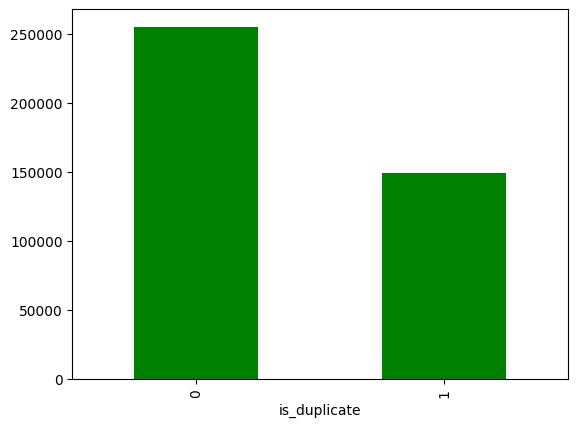

In [4]:
print(data['is_duplicate'].value_counts())
import matplotlib.pyplot as plt
data['is_duplicate'].value_counts().plot(kind='bar', color='green')

In [5]:
data.shape

(404290, 6)

In [6]:
print(data.dtypes)
print(data['question1'].dtypes)
print(data['question2'].dtypes)
type(data['question1'])

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object
object
object


pandas.core.series.Series


# Converting Target or label for input in LIST

In [7]:
t_label = list(data['is_duplicate'])
print(t_label[:10])

[0, 0, 0, 0, 0, 1, 0, 1, 0, 0]


# Storing 'question1' and 'question2' column in diff. variables

In [8]:
question_one=data['question1'].astype(str)
print(question_one.head())

0              What is the step by step guide to invest in share market in india?
1                             What is the story of Kohinoor (Koh-i-Noor) Diamond?
2       How can I increase the speed of my internet connection while using a VPN?
3                              Why am I mentally very lonely? How can I solve it?
4    Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?
Name: question1, dtype: object


In [9]:
question_two=data['question2'].astype(str)
print(question_two.head())

0                          What is the step by step guide to invest in share market?
1    What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) d...
2                        How can Internet speed be increased by hacking through DNS?
3                  Find the remainder when [math]23^{24}[/math] is divided by 24,23?
4                                            Which fish would survive in salt water?
Name: question2, dtype: object


# Fitting text on a single tokenized object

In [10]:
#from keras.preprocessing.text import Tokenizer
tok_all = Tokenizer(filters='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', lower=True, char_level = False)
tok_all.fit_on_texts(question_one+question_two)
#tok_all.fit_on_texts(question_one+question_two+question_one_test+question_two_test)

In [11]:
vocabulary_all=len(tok_all.word_counts)
print(vocabulary_all)

89983


# Train data Sequencing and Encoding

In [12]:
#Encoding question 1
encoded_q1=tok_all.texts_to_sequences(question_one)
print(question_one[0])
encoded_q1[0]

What is the step by step guide to invest in share market in india?


[2, 3, 1, 1222, 59, 1222, 2566, 7, 579, 8, 763, 384, 8, 36]

In [13]:
#Encoding question 2
encoded_q2=tok_all.texts_to_sequences(question_two)
print(question_two[0])
encoded_q2[0]

What is the step by step guide to invest in share market?


[2, 3, 1, 1222, 59, 1222, 2566, 7, 579, 8, 763, 384]

# Pre-Padding on Train data

In [14]:
#####Padding encoded sequence of words
from keras.preprocessing import sequence
max_length=100
padded_docs_q1 = sequence.pad_sequences(encoded_q1, maxlen=max_length, padding='pre')

In [15]:
#####Padding encoded sequence of words
from keras.preprocessing import sequence
max_length=100
padded_docs_q2 = sequence.pad_sequences(encoded_q2, maxlen=max_length, padding='pre')

# Reading Embedding Vector from Glove

In [16]:
embeddings_index = {}
f = open('/kaggle/input/glove360/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [17]:
#create embedding matrix

embedding_matrix = np.zeros((vocabulary_all+1, 300))
for word, i in tok_all.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		# words not found in embedding index will be all-zeros.
		embedding_matrix[i] = embedding_vector

## initialization of some variables

In [18]:

VALIDATION_SPLIT = 0.3
RATE_DROP_LSTM = 0.17
RATE_DROP_DENSE = 0.25
NUMBER_DENSE_UNITS = 64
ACTIVATION_FUNCTION = 'relu' 

In [19]:

rate_drop_lstm = RATE_DROP_LSTM
number_dense_units = NUMBER_DENSE_UNITS
activation_function = ACTIVATION_FUNCTION
rate_drop_dense = RATE_DROP_DENSE
validation_split_ratio = VALIDATION_SPLIT

# 3rd feature ("Length of common words") extraction from encoded_q1 and encoded_q2 

In [20]:
def commonWords():
   # leak data
   length_features = [[len(set(x1)), len(set(x2)), len(set(x1).intersection(x2))] for x1, x2 in zip(encoded_q1, encoded_q2)]
   length_features = np.array(length_features)
   return length_features
length_features= commonWords()

# Convert labels from 1d array into 2d array

In [21]:
import numpy as np
#from keras.utils.np_utils import to_categorical
label_twoDimension = to_categorical(data['is_duplicate'], num_classes=2)

# Split data into train and test

In [22]:
from sklearn.model_selection import train_test_split
text_train_q1, text_test_q1, text_train_q2, text_test_q2, length_features_train, length_features_test, label_train, label_test = train_test_split(padded_docs_q1, padded_docs_q2, length_features, label_twoDimension, test_size=0.3, random_state=42)


# Making of model with Bi-lstm and 3rd feature

In [23]:
# Adding Embedding layer
embedding_layer = (Embedding(vocabulary_all+1,300,weights=[embedding_matrix], input_length=max_length, trainable=False))          


# Creating LSTM Encoder
lstm_layer = Bidirectional(LSTM(64,  dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm))

# Creating LSTM Encoder layer for First Sentence
sequence_1_input = Input(shape=(max_length,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)

# Creating LSTM Encoder layer for Second Sentence
sequence_2_input = Input(shape=(max_length,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
x2 = lstm_layer(embedded_sequences_2)

#########################################################################
############# "Important 'leak' input layer of this model" ##############
#########################################################################

# Creating leaks input
wordLength_input = Input(shape=(length_features_train.shape[1],))              
wordLength_dense = Dense(int(number_dense_units/2), activation=activation_function)(wordLength_input)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [24]:
# Merging two LSTM encodes vectors from sentences to pass it to dense layer applying dropout and batch normalisation
merged = concatenate([x1, x2, wordLength_dense])
merged = BatchNormalization()(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = Dense(number_dense_units, activation=activation_function)(merged)
merged = BatchNormalization()(merged)
merged = Dropout(rate_drop_dense)(merged)
preds = Dense(2, activation='sigmoid')(merged)

model = Model(inputs=[sequence_1_input, sequence_2_input, wordLength_input], outputs=preds)
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])

In [25]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 300)       │     26,995,200 │ input_layer[0][0],     │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 128)            │        186,880 │ embedding[0][0],       │
│ (Bidirectional)           │                        │                │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │            128 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 288)            │              0 │ bidirectional[0][0],   │
│                           │                        │                │ bidirectional[1][0],   │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 288)            │          1,152 │ concatenate[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 288)            │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │         18,496 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64)             │            256 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │            130 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 27,202,242 (103.77 MB)

 Trainable params: 206,338 (806.01 KB)

 Non-trainable params: 26,995,904 (102.98 MB)

# Model ploting

In [ ]:
plot_model(model, to_file='model_lstm2_3rd_feature.png')
from IPython.display import Image
Image(filename='model_lstm2_3rd_feature.png') 

# **Making of "earlystopper" , "checkpointer" & "reduce_lr"**

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define EarlyStopping, ModelCheckpoint, and ReduceLROnPlateau
earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(filepath='lstm_model_three_.{epoch:02d}-{val_loss:.6f}.weights.h5',  # Change extension to .weights.h5
                               verbose=1, save_best_only=True, save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=2, min_lr=0.00001, verbose=1)


# Model fitting or training

In [28]:
history = model.fit([text_train_q1, text_train_q2, length_features_train], label_train,validation_data=([text_test_q1, text_test_q2, length_features_test], label_test),epochs=200, batch_size=1024,callbacks=[earlystopper, checkpointer, reduce_lr],verbose=1)

Epoch 1/200
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - acc: 0.6628 - loss: 0.6477
Epoch 1: val_loss improved from inf to 0.48280, saving model to lstm_model_three_.01-0.482796.weights.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 114s 371ms/step - acc: 0.6630 - loss: 0.6474 - val_acc: 0.7438 - val_loss: 0.4828 - learning_rate: 0.0010
Epoch 2/200
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - acc: 0.7518 - loss: 0.4767
Epoch 2: val_loss improved from 0.48280 to 0.44328, saving model to lstm_model_three_.02-0.443277.weights.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 102s 370ms/step - acc: 0.7518 - loss: 0.4767 - val_acc: 0.7735 - val_loss: 0.4433 - learning_rate: 0.0010
Epoch 3/200
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - acc: 0.7672 - loss: 0.4523
Epoch 3: val_loss improved from 0.44328 to 0.42736, saving model to lstm_model_three_.03-0.427360.weights.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 102s 367ms/step - acc: 0.7672 - loss: 0.4522 - val_acc: 0.7838 - val_loss: 0.4274 - learning_rate: 0.0010
Epoch 4/200
277/277 

In [29]:
from keras.models import load_model
model.save('siemse_lstm_3_with_3rd_feature.h5')

# Final train and val loss

In [30]:
min_val_loss = min(history.history["val_loss"])
min_train_loss = min(history.history["loss"])
max_val_acc = max(history.history["val_acc"])
max_train_acc = max(history.history["acc"])
print("min_train_loss=%g, min_val_loss=%g, max_train_acc=%g, max_val_acc=%g" % (min_train_loss,min_val_loss,max_train_acc,max_val_acc))

min_train_loss=0.32396, min_val_loss=0.357189, max_train_acc=0.848959, max_val_acc=0.8322


# Plot epoch Vs loss

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

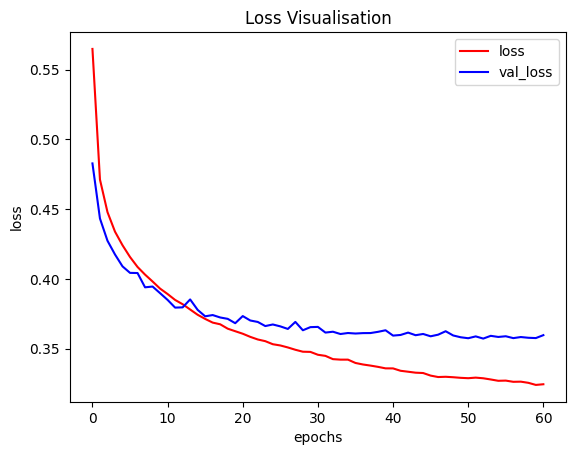

In [31]:
from matplotlib import pyplot as plt
plt.plot(history.history["loss"],color = 'red', label = 'loss')
plt.plot(history.history["val_loss"],color = 'blue', label = 'val_loss')
plt.title('Loss Visualisation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig('loss_siamese_lstm_3_with_3rd_feature.pdf',dpi=1000)

from google.colab import files
files.download('loss_siamese_lstm_3_with_3rd_feature.pdf') 

# Plot Epoch Vs Accuracy

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

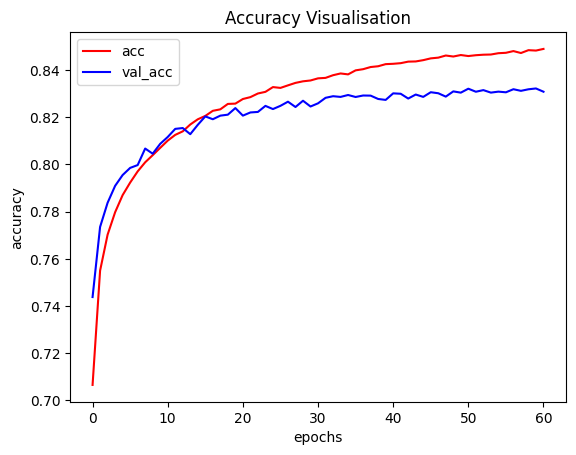

In [32]:
plt.plot(history.history["acc"],color = 'red', label = 'acc')
plt.plot(history.history["val_acc"],color = 'blue', label = 'val_acc')
plt.title('Accuracy Visualisation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('acc_siamese_lstm_3_with_3rd_feature.pdf',dpi=1000)
files.download('acc_siamese_lstm_3_with_3rd_feature.pdf') 

# Classification report

In [33]:
model_predictions = model.predict([text_test_q1, text_test_q2, length_features_test])

3791/3791 ━━━━━━━━━━━━━━━━━━━━ 296s 78ms/step


In [34]:
predictions = np.zeros_like(model_predictions)
predictions[np.arange(len(model_predictions)), model_predictions.argmax(1)] = 1

In [35]:
#predictionInteger=(np.argmax(predictions, axis=1))
#predictionInteger

In [36]:
from sklearn.metrics import classification_report
print(classification_report(label_test,predictions))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86     76350
           1       0.75      0.81      0.78     44937

   micro avg       0.83      0.83      0.83    121287
   macro avg       0.82      0.83      0.82    121287
weighted avg       0.84      0.83      0.83    121287
 samples avg       0.83      0.83      0.83    121287



# Log Loss

In [37]:
from sklearn.metrics import log_loss
log_loss_val= log_loss(label_test,model_predictions)
log_loss_val

0.3596481391910963